# Data Exploration & Dataset Creation

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from globals import movielens_path, item_metadata_file, train_set_file, val_set_file, test_set_file, seed, user_ratings_file, user_embeddings_file, full_matrix_file, imdb_path, movie_imdb_df_file
from util import multi_hot_encode
import warnings

# Parameters:

In [22]:
extract_features = True
recalculate_metadata = True   # can be false if we do not change the rest of the parameters
use_audio = False

# arbitrary util matrix filters
LIMIT_USERS = None
MIN_VOTES_PER_ITEM = 1800
MIN_VOTES_PER_USER = 70
MAX_VOTES_PER_USER = 300
HARD_LIMIT_ITEMS = None
HARD_LIMIT_USERS = 5000

# item metadata filters
MIN_YEAR = 2000
MIN_APPEARANCES = 3       # minimum number of appearances for a movie's personel (e.g. actor, director, etc) in other movies (in our dataset) in order to keep him in the metadata extracted

save_user_ratings = True
use_genome_tags = True
create_user_embeddings_too = True

val_size = 0.1
test_size = 0.1

## Define some utility functions

In [3]:
def util_matrix_stats(matrix: pd.DataFrame):
    print(f"# users: {matrix.index.unique().shape[0]}")
    print(f"# movies: {matrix['movieId'].unique().shape[0]}")
    print(f"# ratings: {matrix.shape[0]}")

def explore_utility_matrix(R: pd.DataFrame):
    plt.title('Item rating distribution')
    plt.xlabel('Average Rating')
    plt.ylabel('# of items')
    R.groupby('movieId')['rating'].mean().hist(bins=20)
    plt.show()
    
    plt.title('Item popularity')
    plt.xlabel('Number of interactions')
    plt.ylabel('# of items')
    R.groupby('movieId')['rating'].count().hist(bins=100)
    plt.show()
    
    plt.title('User popularity')
    plt.xlabel('Number of interactions')
    plt.ylabel('# of users')
    R.groupby('userId')['rating'].count().hist(bins=100)
    plt.show()

## Data loading, pruning and feature extraction

### Load utility matrix

In [4]:
def load_user_ratings(movielens_data_folder, LIMIT_USERS=None, seed=None):
    """ Load MovieLens data """
    # load movielens user reviews data
    user_ratings = pd.read_csv(movielens_data_folder + 'ratings.csv',
                               index_col='userId',
                               usecols=['userId', 'movieId', 'rating', 'timestamp'],
                               dtype={'userId': np.int32, 'movieId': np.int32, 'rating': np.float32})
    if LIMIT_USERS is not None:
        print('Limiting number of users to', LIMIT_USERS)
        # user_ratings = user_ratings.loc[1: LIMIT_USERS]
        user_ratings = user_ratings.loc[user_ratings.index.max() - LIMIT_USERS: user_ratings.index.max()]
        user_ratings = user_ratings.loc[user_ratings.index.sample(n=LIMIT_USERS, random_state=seed)]

    # load genome tags supplied with movielens
    genometags = pd.read_csv(movielens_data_folder + 'genome-scores.csv',
                             index_col='movieId',
                             usecols=['movieId', 'tagId', 'relevance'],
                             dtype={'movieId': np.int32, 'tagId': np.int32, 'relevance': np.float64})
    genometags = genometags.pivot_table('relevance', index='movieId', columns='tagId')

    # change movieId to IMDb ID, link movieIds with imdbIds
    links = pd.read_csv(movielens_data_folder + 'links.csv',
                        index_col='movieId',
                        usecols=['movieId', 'imdbId'],
                        dtype={'movieId': np.int32, 'imdbId': 'string'})
    user_ratings['movieId'] = 'tt' + user_ratings['movieId'].map(links['imdbId'])
    genometags.index = 'tt' + genometags.index.map(links['imdbId'])
    genometags.rename({c: f'genome_{c}' for c in genometags.columns.tolist()}, inplace=True, axis=1)   # needed for concat to work later

    return user_ratings, genometags

In [5]:
utility_matrix, genome_metadata = load_user_ratings(movielens_path, LIMIT_USERS=LIMIT_USERS, seed=seed)
utility_matrix

,movieId,rating,timestamp
userId,,,
1,tt0110912,5.0,1147880044
1,tt0111495,3.5,1147868817
1,tt0108394,5.0,1147868828
1,tt0114787,5.0,1147878820
1,tt0045152,3.5,1147868510
...,...,...,...
162541,tt0382932,4.5,1240953372
162541,tt0389790,2.5,1240951998
162541,tt0952640,2.0,1240950697


# users: 162541
# movies: 59047
# ratings: 25000095


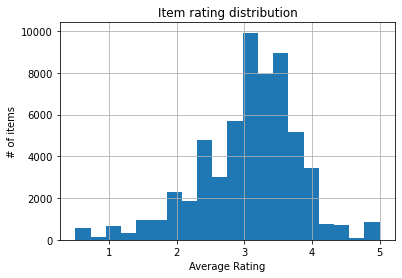

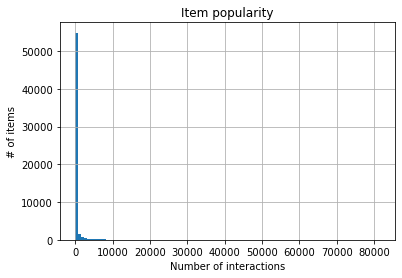

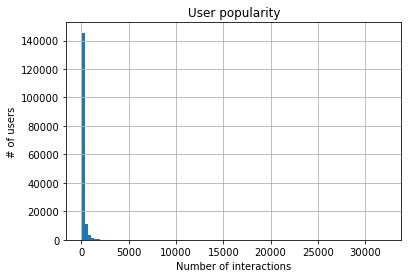

In [6]:
util_matrix_stats(utility_matrix)
explore_utility_matrix(utility_matrix)

### Filter items

In [7]:
def filter_items(utility_matrix, MIN_VOTES_PER_ITEM, HARD_LIMIT_ITEMS, seed): 
    # filter by item popularity
    if MIN_VOTES_PER_ITEM is not None:
        item_votes = utility_matrix.groupby('movieId')['rating'].count()
        print('Original items:', len(item_votes))
        item_votes = item_votes[item_votes >= MIN_VOTES_PER_ITEM]
        print(f'Keeping {len(item_votes)} items based on number of votes >= {MIN_VOTES_PER_ITEM}')
        utility_matrix = utility_matrix[utility_matrix['movieId'].isin(item_votes.index)]
        assert utility_matrix.groupby('movieId')['rating'].count().min() >= MIN_VOTES_PER_ITEM
        
    # randomly filter items to desired amount (!) Before we filter users as this also influences the latter
    if HARD_LIMIT_ITEMS is not None:
        items = pd.Series(utility_matrix['movieId'].unique()).sample(HARD_LIMIT_ITEMS, random_state=seed)
        utility_matrix = utility_matrix[utility_matrix['movieId'].isin(items)]
    
    print('Utility matrix:', utility_matrix.shape)
    return utility_matrix


def filter_users(utility_matrix, MIN_VOTES_PER_USER, MAX_VOTES_PER_USER, HARD_LIMIT_USERS, seed): 
    # filter by user voting
    if MIN_VOTES_PER_USER is not None:
        user_votes = utility_matrix.groupby('userId')['rating'].count()
        print('Original users:', len(user_votes))
        user_votes = user_votes[user_votes >= MIN_VOTES_PER_USER]  # at least these many votes on movies
        print(f'Keeping {len(user_votes)} users based on number of votes >= {MIN_VOTES_PER_USER}')
        utility_matrix = utility_matrix[utility_matrix.index.isin(user_votes.index)]
        assert utility_matrix.groupby('userId')['rating'].count().min() >= MIN_VOTES_PER_USER
        
    if MAX_VOTES_PER_USER is not None:
        user_votes = utility_matrix.groupby('userId')['rating'].count()
        print('Original users:', len(user_votes))
        user_votes = user_votes[user_votes <= MAX_VOTES_PER_USER]  # at least these many votes on movies
        print(f'Keeping {len(user_votes)} users based on number of votes <= {MAX_VOTES_PER_USER}')
        utility_matrix = utility_matrix[utility_matrix.index.isin(user_votes.index)]
        assert utility_matrix.groupby('userId')['rating'].count().max() <= MAX_VOTES_PER_USER
    
    # randomly filter users to desired amount
    if HARD_LIMIT_USERS is not None:
        users = utility_matrix.index.unique().to_series().sample(HARD_LIMIT_USERS, random_state=seed)
        utility_matrix = utility_matrix[utility_matrix.index.isin(users)]
    
    print('Utility matrix:', utility_matrix.shape)
    return utility_matrix

First, we filter the items. They will also be filtered down (unavoidable) later to exclude those we do not have features for.

Original items: 59047
Keeping 2613 items based on number of votes >= 1800
Utility matrix: (20557695, 3)
# users: 162535
# movies: 2613
# ratings: 20557695


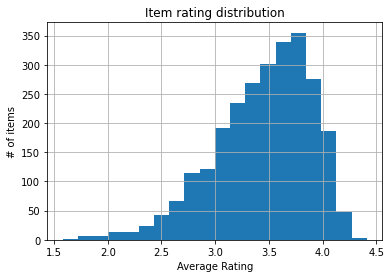

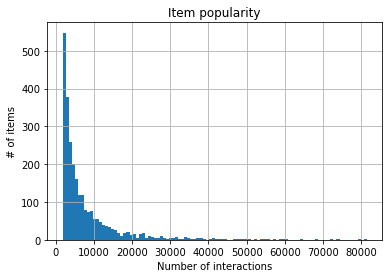

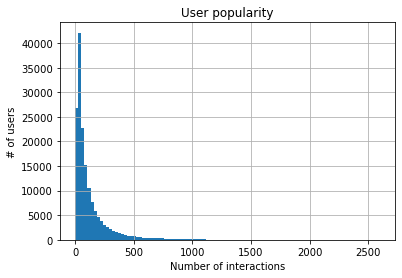

In [8]:
utility_matrix = filter_items(utility_matrix, MIN_VOTES_PER_ITEM, HARD_LIMIT_ITEMS, seed=seed)

util_matrix_stats(utility_matrix)
explore_utility_matrix(utility_matrix)

### Extract features for items

Load metadata from IMDB for however many movies you find.

In [9]:
def load_imdb_dfs(unique_movies: pd.Series, MIN_VOTES=100, MIN_YEAR=MIN_YEAR):
    # load each file with tconst (title id) as index
    print('Loading IMDB data...')
    tconst_files = [
        ('title.basics.tsv', None),
        ('title.ratings.tsv', None)
    ]
    all_dfs = []
    for file, usecols in tconst_files:
        df = pd.read_csv(imdb_path + file, index_col='tconst',  usecols=usecols,
                         sep='\t', encoding='utf-8',
                         keep_default_na=False, na_values=['\\N'])
        all_dfs.append(df)

    # combine all into one big fat DataFrame
    print('concatenating...')
    movies_df = pd.concat(all_dfs, axis=1)
    print('Reducing size to movies given...')
    movies_df = movies_df[(movies_df['titleType'].isin(['tvMovie', 'movie'])) &
                          (movies_df.index.isin(unique_movies.index))]
    print('done')

    # fix NA and types afterwards as it is not supported for read_csv
    movies_df['numVotes'] = movies_df['numVotes'].fillna(0).astype(np.uint16)
    movies_df['isAdult'] = movies_df['isAdult'].astype(bool)
    movies_df['startYear'] = movies_df['startYear'].fillna(0).astype(np.uint16)
    movies_df['endYear'] = movies_df['endYear'].fillna(0).astype(np.uint16)
    movies_df['genres'] = movies_df['genres'].fillna('').astype(str)

    # filtering
    movies_df = movies_df[(movies_df['numVotes'] >= MIN_VOTES) &
                          (movies_df['startYear'] >= MIN_YEAR) &
                          (~(movies_df['genres'].str.contains('Short', regex=False, na=False))) &
                          (movies_df['genres'].str != '')]

    print('Loading edges')
    principals_df = pd.read_csv(imdb_path + 'title.principals.tsv',
                                sep='\t',
                                encoding='utf-8',
                                keep_default_na=False,
                                na_values=['\\N'],
                                index_col='tconst',
                                usecols=['tconst', 'nconst', 'category'])
    principals_df = principals_df[principals_df.index.isin(movies_df.index)]
    principals_df = principals_df[principals_df['category'].isin(['actor', 'actress', 'writer', 'director', 'composer'])]

    # print(movies_df)
    # print(movies_df.shape)
    # print(principals_df)
    # print(principals_df.shape)

    return movies_df, principals_df


def load_imdb_metadata_features(unique_movies: pd.Series, MIN_APPEARANCES=MIN_APPEARANCES, save=True):
    movies_df, principals_df = load_imdb_dfs(unique_movies)
    
    # reduce unique_movies to the ones in movies_df TODO
    print(f'before: {len(unique_movies)}')
    print(unique_movies)
    unique_movies = unique_movies[(unique_movies.index.isin(movies_df.index)) & (unique_movies.index.isin(principals_df.index))]
    print(f'after: {len(unique_movies)}')
    
    assert len(unique_movies) > 0

    if save:
        movies_df.to_csv(movie_imdb_df_file + '.csv', columns=['genres'], mode='w')

    all_genres = [
        'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',  'Fantasy',
        'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',  'Thriller', 'War', 'Western', 'Biography', 'Music',
        'History', 'Family', 'Sport'
        # Rare (for now) categories: 'Film-Noir', 'Children'
    ]

    # Don't actually need to do this separately:
    # actors_mask = (principals_df['category'] == 'actor') | (principals_df['category'] == 'actress')
    # all_actors = sorted(list(principals_df['nconst'][actors_mask].unique()))
    #
    # directors_mask = principals_df['category'] == 'director'
    # all_directors = sorted(list(principals_df['nconst'][directors_mask].unique()))
    #
    # composer_mask = principals_df['category'] == 'composer'
    # all_composers = sorted(list(principals_df['nconst'][composer_mask].unique()))

    print('Number of personel:', len(principals_df), f'. Removing those with less than {MIN_APPEARANCES} appearances...')
    reduced_principals_df = principals_df.groupby('nconst').filter(lambda x: len(x) >= MIN_APPEARANCES)
    print(f'Left with {len(reduced_principals_df)}')

    all_personnel = sorted(list(reduced_principals_df['nconst'].unique()))

    F = len(all_genres) + len(all_personnel)
    features = np.zeros((len(unique_movies), F))
    for i, movieId in tqdm(enumerate(unique_movies.index), total=len(unique_movies)):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # multi-hot encode genres
            genres = movies_df.loc[movieId]['genres'].split(',')
            genres = set([g.replace(' ', '') for g in genres])
            genres_feat = multi_hot_encode([genres], all_genres)
            # multi-hot encode personel
            personnel = set(principals_df.loc[movieId]['nconst'])
            personnel_feat = multi_hot_encode([personnel], all_personnel)
        
        # put together for features
        features[i, :len(all_genres)] = genres_feat
        features[i, len(all_genres):] = personnel_feat
    
    return pd.DataFrame(index=unique_movies.index, data=features), movies_df

In [10]:
if extract_features:
    # load audio features
    if use_audio:
        audio_features = pd.read_csv('../data/audio_features.csv', index_col='movieId', sep=';')
        # filter utility matrix to contain only movies for which we have audio
        utility_matrix = utility_matrix[utility_matrix['movieId'].isin(audio_features.index)]
        # utility_matrix = audio_features.join(utility_matrix, on='movieId', how='inner')
        print('Samples after keeping only audio movies:', utility_matrix.shape[0])
    
    # util_matrix_stats(utility_matrix)
    # assert len(utility_matrix) < 10000000, f"Utility matrix is going too be too big: {len(utility_matrix)}"
    
    # load movie features from only for movies in movieLens (for which we have ratings)
    if recalculate_metadata:
        print('Recalculating metadata...')
        unique_movies = pd.Series(index=utility_matrix['movieId'].unique().copy())
        imdb_metadata, movies_df = load_imdb_metadata_features(unique_movies)
        if use_genome_tags:
            genome_metadata = genome_metadata[genome_metadata.index.isin(unique_movies.index)]
            metadata = imdb_metadata.join(genome_metadata)
            metadata = metadata.fillna(0.0)   # shouldn't be any but just in case
        else:
            metadata = imdb_metadata
        
        # save metadata
        print(f'Found {metadata.shape[0]} movies.\nSaving metadata...')
        metadata.to_hdf(item_metadata_file + '.h5', key='metadata', mode='w')
        print('OK!')
    else:
        metadata = pd.read_hdf(item_metadata_file + '.h5', key='metadata')
        movies_df = None
    
    # Note: there can still be movies in ratings for which we have no features
    # so remove them like this:
    print('Removing movies for which we have no features...')
    utility_matrix = utility_matrix[utility_matrix['movieId'].isin(metadata.index)]
    
    # Note to check statistics: metadata.sum(axis=0)
    print("Metadata: ", metadata.shape)
    # print('Statistics:')
    # print(metadata.sum(axis=0))
    
    util_matrix_stats(utility_matrix)


Recalculating metadata...


C:\Users\mikem\AppData\Local\Temp/ipykernel_4196/1827369287.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unique_movies = pd.Series(index=utility_matrix['movieId'].unique().copy())


Loading IMDB data...


C:\Users\mikem\AppData\Local\Temp/ipykernel_4196/685920492.py:56: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  movies_df, principals_df = load_imdb_dfs(unique_movies)


concatenating...
Reducing size to movies given...
done
Loading edges
before: 2613
tt0110912   NaN
tt0111495   NaN
tt0108394   NaN
tt0045152   NaN
tt0092890   NaN
             ..
tt0056217   NaN
tt1655442   NaN
tt0335119   NaN
tt0158811   NaN
tt0086034   NaN
Length: 2613, dtype: float64
after: 1073
Number of personel: 8134 . Removing those with less than 3 appearances...
Left with 4309


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [00:00<00:00, 2647.26it/s]
C:\Users\mikem\miniconda3\envs\data-science-env\lib\site-packages\pandas\io\pytables.py:314: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)


Found 1073 movies.
Saving metadata...
OK!
Removing movies for which we have no features...


C:\Users\mikem\miniconda3\envs\data-science-env\lib\site-packages\pandas\io\pytables.py:314: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  f(store)


Metadata:  (1073, 1976)
# users: 117078
# movies: 1073
# ratings: 7261331


### Filter users

Now, after being done with items, we filter the users so that they have the desired properties.

Original users: 117078
Keeping 30766 users based on number of votes >= 70
Original users: 30766
Keeping 27068 users based on number of votes <= 300
Utility matrix: (688100, 3)
# users: 5000
# movies: 1073
# ratings: 688100


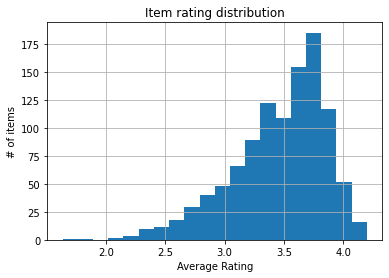

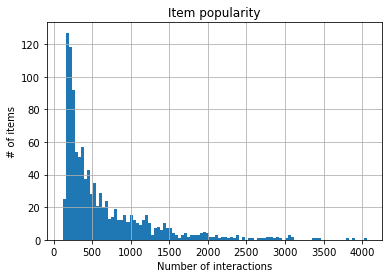

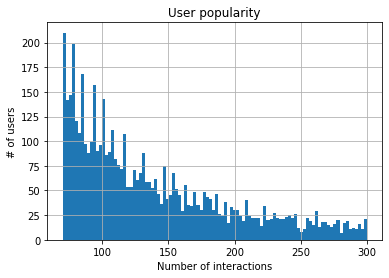

In [11]:
# filter again to make sure we get what we wanted
utility_matrix = filter_users(utility_matrix, MIN_VOTES_PER_USER, MAX_VOTES_PER_USER, HARD_LIMIT_USERS, seed=seed)

util_matrix_stats(utility_matrix)
explore_utility_matrix(utility_matrix)

### Examine item metadata

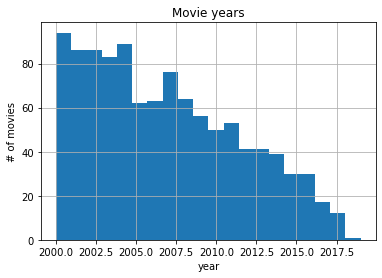

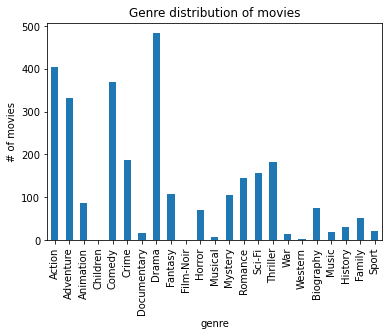

In [12]:
def examine_items(movies_df):
    # years
    plt.title("Movie years")
    plt.xlabel("year")
    plt.ylabel("# of movies")
    movies_df['startYear'].hist(bins=20)
    plt.show()
    
    # genres
    all_genres = [
        'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',  'Fantasy',
        'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',  'Thriller', 'War', 'Western', 'Biography', 'Music',
        'History', 'Family', 'Sport'
    ]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        m = movies_df['genres'].apply(lambda x: multi_hot_encode([x.split(',')], all_genres)[0])
    m = pd.DataFrame(m.to_list(), columns=all_genres)
    
    plt.title("Genre distribution of movies")
    plt.xlabel("genre")
    plt.ylabel("# of movies")
    m.sum(axis=0).plot.bar()
    plt.show()
    
    # TODO: others?
    

if extract_features and movies_df is not None:
    examine_items(movies_df)

## Train-val-test split

There are many ways to perform train-val-test split depending on which generalization ability we are interested in measuring (i.e. depending on our task) (training is not affected). 

In [23]:
def train_val_test_split_flat(utility_matrix, val_size, test_size, seed):
    """ Random split on all interactions of the utility matrix
        Doesn't measure generalization to new users or items, only to unknown interactions between known user/items as in pure CF
    """
    
    # set random seed for reproducability
    np.random.seed(seed)

    # determine splits in a shuffled order of all samples like so:
    # | <-- val set --> | <-- test set --> | <--------- train set ---------> |
    size = len(utility_matrix)
    val_split = int(np.floor(val_size * size))
    test_split = val_split + int(np.floor(test_size * size))

    # randomly shuffly the indexes of all data
    indices = list(range(size))
    np.random.shuffle(indices)

    # apply splits to get mutually exclusive subsets of the original data
    val = utility_matrix.iloc[indices[:val_split]]
    test = utility_matrix.iloc[indices[val_split: test_split]]
    train = utility_matrix.iloc[indices[test_split:]]
    
    return train, val, test


def train_val_test_split_leave_percentage(utility_matrix, val_size, test_size, seed):
    """ Randomly select val_num, test_num interactions per user to hold out for val and test sets.
        Equally represents each user in the val/test sets despite how many interaction he has overall.
    """
    
    # set random seed for reproducability
    np.random.seed(seed)
    
    # get users from matrix
    users = utility_matrix.index.unique().to_series()

    train, val, test = [], [], []
    for u in tqdm(users, total=len(users)):
        user_interactions = utility_matrix.loc[u]
        
        # determine splits in a shuffled order of all samples like so:
        # | <-- val set --> | <-- test set --> | <--------- train set ---------> |
        size = len(user_interactions)
        val_split = max(int(np.floor(val_size * size)), 2)
        test_split = val_split + max(int(np.floor(test_size * size)), 2)

        # randomly shuffly the indexes of all users
        indices = list(range(size))
        np.random.shuffle(indices)
        
        # apply splits
        val.append(user_interactions[:val_split])
        test.append(user_interactions[val_split: test_split])
        train.append(user_interactions[test_split:])
    
    train = pd.concat(train)
    val = pd.concat(val)
    test = pd.concat(test)
    
    return train, val, test




def train_val_test_split_leave_k(utility_matrix, val_num, test_num, seed):
    """ Randomly select val_num, test_num interactions per user to hold out for val and test sets.
        Equally represents each user in the val/test sets despite how many interaction he has overall.
    """
    
    # set random seed for reproducability
    np.random.seed(seed)
    
    # get users from matrix
    users = utility_matrix.index.unique().to_series()

    train, val, test = [], [], []
    for u in tqdm(users, total=len(users)):
        user_interactions = utility_matrix.loc[u]
        
        # determine splits in a shuffled order of all samples like so:
        # | <-- val set --> | <-- test set --> | <--------- train set ---------> |
        assert val_num + test_num < len(user_interactions) / 2, "Choose lower val and test nums"
        val_split = val_num
        test_split = val_num + test_num

        # randomly shuffly the indexes of all users
        size = len(user_interactions)
        indices = list(range(size))
        np.random.shuffle(indices)
        
        # apply splits
        val.append(user_interactions[:val_split])
        test.append(user_interactions[val_split: test_split])
        train.append(user_interactions[test_split:])
    
    train = pd.concat(train)
    val = pd.concat(val)
    test = pd.concat(test)
    
    return train, val, test


def train_val_test_split_on_users(utility_matrix, val_size, test_size, seed):
    """ Random split on users of the utility matrix. All interactions associated with a user go with him on the same set. 
        Measures generalization to new users but considers items fixed.
    """
    
    # set random seed for reproducability
    np.random.seed(seed)
    
    # get users from matrix
    users = utility_matrix.index.unique().to_series()

    # determine splits in a shuffled order of all samples like so:
    # | <-- val set --> | <-- test set --> | <--------- train set ---------> |
    size = len(users)
    val_split = int(np.floor(val_size * size))
    test_split = val_split + int(np.floor(test_size * size))

    # randomly shuffly the indexes of all users
    indices = list(range(size))
    np.random.shuffle(indices)
    
    # apply splits to users and from them get mutually exclusive subsets of the original data
    val = utility_matrix.loc[users.iloc[indices[:val_split]]]
    test = utility_matrix.loc[users.iloc[indices[val_split: test_split]]]
    train = utility_matrix.loc[users.iloc[indices[test_split:]]]
    
    return train, val, test

In [24]:
# TODO: Which of the two splitting methods?
# train, val, test = train_val_test_split_leave_k(utility_matrix, val_num=5, test_num=5, seed=seed)
# train, val, test = train_val_test_split_leave_percentage(utility_matrix, val_size, test_size, seed)
train, val, test = train_val_test_split_flat(utility_matrix, val_size, test_size, seed)
train.shape[0], val.shape[0], test.shape[0]

(550480, 68810, 68810)

In [25]:
# train.shape[0], val.shape[0], test.shape[0]

Save sets.

In [26]:
def save_set(matrix: pd.DataFrame, name: str):
    matrix.to_csv(name + '.csv', columns=['movieId', 'rating'], mode='w')

save_set(train, train_set_file)
save_set(val, val_set_file)
save_set(test, test_set_file)
save_set(utility_matrix, full_matrix_file)

Exploration of sets. Remember that, if we are flat splitting, each user will potentially have interactions randomly distributed across all sets.

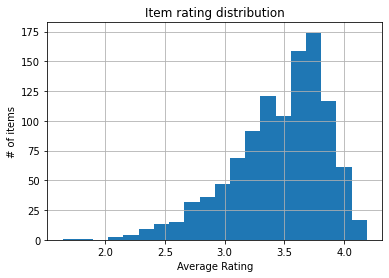

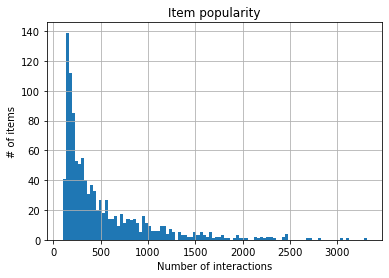

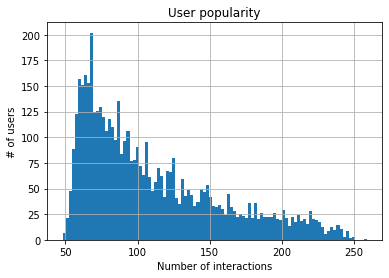

In [27]:
explore_utility_matrix(train)

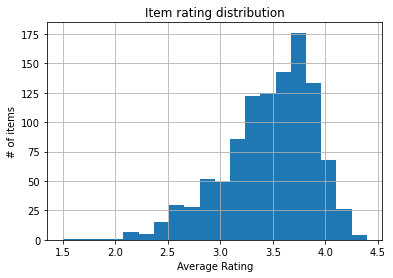

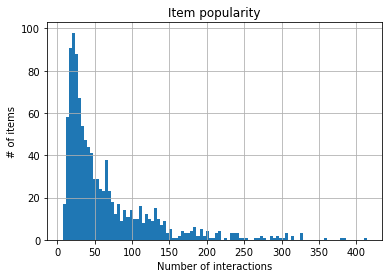

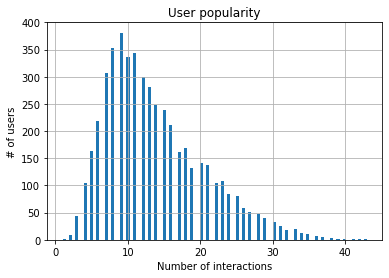

In [28]:
explore_utility_matrix(val)

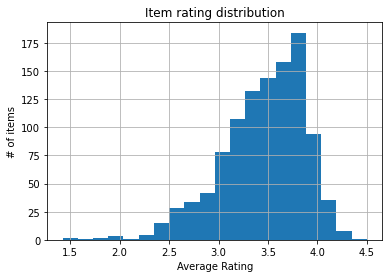

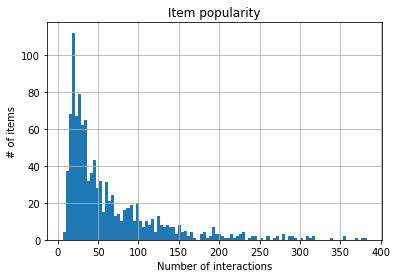

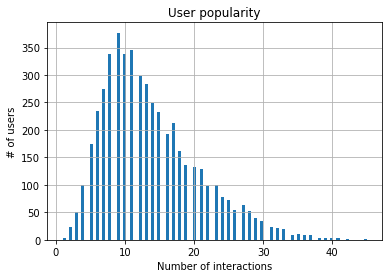

In [29]:
explore_utility_matrix(test)

## Extract user ratings and fixed user embeddings from features

(5000, 4)
User ratings:
                                                    rating  \
userId                                                      
38      [3.5, 4.5, 2.0, 3.0, 3.5, 3.5, 3.0, 3.5, 4.0, ...   
62      [4.5, 4.5, 4.0, 4.5, 4.5, 4.0, 4.0, 4.5, 4.0, ...   
113     [4.5, 2.0, 4.0, 4.5, 3.0, 3.5, 3.0, 3.0, 3.0, ...   
155     [4.5, 3.0, 3.5, 2.0, 3.5, 4.0, 5.0, 4.0, 4.5, ...   
195     [4.0, 4.0, 4.0, 3.0, 4.5, 4.0, 3.5, 4.5, 3.5, ...   
...                                                   ...   
162447  [3.0, 3.5, 3.5, 3.0, 4.0, 3.5, 4.5, 4.5, 3.0, ...   
162452  [4.0, 4.0, 4.5, 3.5, 4.0, 4.0, 5.0, 4.0, 4.0, ...   
162501  [4.0, 4.5, 4.5, 3.5, 4.0, 4.5, 4.5, 5.0, 4.0, ...   
162508  [0.5, 3.0, 4.0, 4.5, 1.5, 0.5, 4.5, 4.0, 5.0, ...   
162512  [4.0, 4.0, 2.5, 3.5, 3.5, 3.0, 3.0, 5.0, 1.5, ...   

                                                  movieId  meanRating  \
userId                                                                  
38      [tt0120630, tt0120737, tt01

C:\Users\mikem\miniconda3\envs\data-science-env\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['rating', 'movieId'], dtype='object')]

  pytables.to_hdf(


OK!


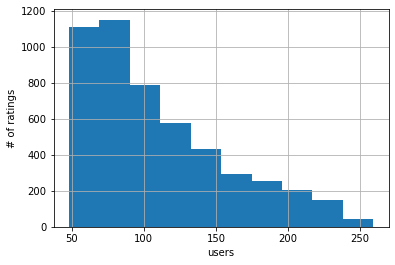

Creating user embeddings...


Creating user embeddings...:  12%|██████████████████▉                                                                                                                                              | 587/5000 [00:01<00:07, 608.32it/s]

In [ ]:
def create_user_embedding(user_ratings: pd.DataFrame, metadata: pd.DataFrame):
    avg_rating = user_ratings['rating'].mean()
    return ((user_ratings['rating'] - avg_rating).reshape(-1, 1) * metadata.loc[user_ratings['movieId']].values).mean(axis=0)


if save_user_ratings:
    
    # TODO: Which should I use? Train would be an obvious choice but what if we re splitting on users
    ratings_to_use = train
    
    
    # IMPORTANT to sort by movieId
    user_ratings: pd.DataFrame = ratings_to_use.drop('timestamp', axis=1).sort_values(by='movieId').groupby(
        'userId').agg({'rating': list, 'movieId': list})
    user_ratings['rating'] = user_ratings['rating'].apply(lambda x: np.array(x))
    user_ratings['movieId'] = user_ratings['movieId'].apply(lambda x: np.array(x))
    user_ratings['meanRating'] = user_ratings['rating'].apply(lambda x: np.mean(x))
    user_ratings['numRatings'] = user_ratings['rating'].apply(lambda x: len(x))
    
    print(user_ratings.shape)
    print('User ratings:\n', user_ratings)

    print('Saving user ratings from train set only...')
    user_ratings.to_hdf(user_ratings_file + '.h5', key='user_ratings', mode='w')
    print('OK!')
    
    # print(f'Average number of ratings per user (in train set): {user_ratings["rating"].apply(lambda x: len(x)).mean()}')
    plt.ylabel("# of ratings")
    plt.xlabel("users")
    user_ratings["rating"].apply(lambda x: len(x)).hist()
    plt.show()
    
    if extract_features and create_user_embeddings_too:
        # create user_embeddings from user ratings once beforehand
        # Note: This takes a very long time
        print('Creating user embeddings...')
        user_embeddings = pd.DataFrame(index=user_ratings.index.unique().copy(), data=np.zeros((len(user_ratings.index.unique()), metadata.shape[1])))
        for userId, user_ratings in tqdm(user_ratings.groupby('userId'), desc='Creating user embeddings...'):
            # Note: iloc[0] is needed because of some weird encapsulation idk
            user_embeddings.at[userId, :] = create_user_embedding(user_ratings.iloc[0], metadata)
        
        print('Saving...')
        user_embeddings.to_hdf(user_embeddings_file + '.h5', key='user_embeddings', mode='w')
        print('Done')

## Create ranking dataset

To create a corresponding dataset with $(user, item, item)$ triplets $(u, i, j)$ where $i$ should be ranked higher than $j$ for user $u$ we do the following. 

TODO: These are quite a lot.. do random sampling here or during each epoch?
TODO: give more weight to triplets with bigger difference or more to ones with less difference? 

In [20]:
np.random.seed(seed)         # set seed (once) for reproducible results
min_samples = 0

def save_ranking_set(matrix: pd.DataFrame, name: str):
    matrix.to_csv(name + '.csv', mode='w', index=False)


# for all sets (except test, since there is no point seeing a ranking loss there) create their corresponding triplets
options = []
for samples, name, frac in zip([train, val], ['train', 'val'], [0.2, 0.25]):
    per_user = samples.groupby(['userId', 'rating']).agg(list) 
    triplets = []
    for (userId, rating), row in tqdm(per_user.iterrows(), total = per_user.shape[0]):
        other_user_ratings = per_user.loc[userId, :]
        other_user_ratings = other_user_ratings[other_user_ratings.index < rating]
        
        if other_user_ratings.shape[0] == 0:      # nothing to pair
            continue        
        
        # for each positive sample
        for movie1 in row['movieId']:
            # sample through all possible negatives (potentially different sample for each positive)
            if frac is not None:
                pool = other_user_ratings.sample(n=max(min_samples, round(frac * other_user_ratings.shape[0])))   # sample at least min_samples for each positive
                options.append(pool.shape[0])
            else:
                pool = other_user_ratings
                
            # if sampled none we will just continue, nothing to iterrow()
            for rating2, row2 in pool.iterrows():
                if rating > rating2:              # probably redundant but just in case
                    for movie2 in row2['movieId']:
                        triplets.append((userId, movie1, movie2))
        
    print(f'Found {len(triplets)} triplets in {name} set!')
    
    triplet_df = pd.DataFrame(triplets, columns=['userId', 'movieId1', 'movieId2'])
    print('Saving set...')
    save_ranking_set(triplet_df, f'../data/ranking_{name}')   # TODO: hardcoded path should be in globals?
    print('Ok!')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39450/39450 [00:54<00:00, 719.53it/s]


Found 4297204 triplets in train set!
Saving set...
Ok!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29142/29142 [00:15<00:00, 1878.02it/s]


Found 228350 triplets in val set!
Saving set...
Ok!


Check how many samples we samples overall.

<AxesSubplot:>

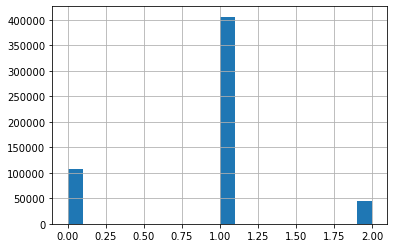

In [21]:
pd.Series(options).hist(bins=20)

In [22]:
imdb_metadata.mean(axis=0).mean()   # macro-average probability that a feature will be non-zero

0.007888744307091805

In [23]:
list(movies_df['primaryTitle'].values)

['Kate & Leopold',
 'In the Mood for Love',
 'State and Main',
 'Chicken Run',
 'Fantastic Four',
 'Frida',
 'From Hell',
 'The Lord of the Rings: The Fellowship of the Ring',
 'Mission: Impossible II',
 'Resident Evil',
 'X-Men',
 'Men in Black II',
 'Titan A.E.',
 "The Emperor's New Groove",
 'Corpse Bride',
 'Star Wars: Episode II - Attack of the Clones',
 'Star Wars: Episode III - Revenge of the Sith',
 'Return to Me',
 'Shrek',
 'Dinosaur',
 'Planet of the Apes',
 'Treasure Planet',
 'Scream 3',
 'Pitch Black',
 'Intolerable Cruelty',
 'The Road to El Dorado',
 'Training Day',
 'U-571',
 'American Psycho',
 'Nutty Professor II: The Klumps',
 'Spider-Man',
 'Thirteen Days',
 'Lara Croft: Tomb Raider',
 'High Fidelity',
 'The Legend of Bagger Vance',
 'Behind Enemy Lines',
 'Cold Mountain',
 "Charlie's Angels",
 'Rules of Engagement',
 'What Lies Beneath',
 'Cast Away',
 'Ghost World',
 'Shaft',
 'Jurassic Park III',
 'The Beach',
 'Hollow Man',
 'The Sum of All Fears',
 'Along Came